In [15]:
from google.colab import drive
drive.mount('/content/drive')

import csv
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from string import punctuation
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification, BertForSequenceClassification, AdamW
import tensorflow as tf
import matplotlib.pyplot as plt

file_path = '/content/drive/My Drive/UofT/IMDB_Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# read dataset
data = csv.reader(open(file_path))
next(data)

# convert positive labels to 1 and negative labels to 0
processed_data = [(review, int(label=='positive')) for review, label in data]

In [18]:
# remove punctuations, special symbols and common stopwords
def clean_data(texts):
    english_stopwords = set(stopwords.words("english"))
    processed_texts = []
    for text, label in texts:
      cleaned_text = []
      text = re.sub(r"<.*?>", "", text)
      text = re.sub(f'[{re.escape(punctuation)}]', ' ', text)
      for token in text.split():
        if token.lower() not in english_stopwords and not token.isdigit():
          cleaned_text.append(token.lower())
      processed_texts.append([' '.join(cleaned_text), label])
    return processed_texts

processed_data = clean_data(processed_data)

# longest = 0
# for example in processed_data:
#   print(len(example[0]))
#   longest = max(longest, len(example[0]))

In [19]:
# print(longest)

# print(processed_data[0])

In [20]:
# randomly split data into 70% training, 10% validation, 20% testing
random.seed(413)
random.shuffle(processed_data)

train_data = processed_data[:35000]
val_data = processed_data[35000:40000]
test_data = processed_data[40000:]

In [21]:
# batch training data
train_dataloader = DataLoader(train_data, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=100, shuffle=True)

In [22]:
# import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
# function to encode a batch of reviews using bert tokenizer
def encode_reviews(batch):
  encoded_dict = tokenizer.batch_encode_plus(batch, max_length=400, padding=True, truncation=True, return_attention_mask=True)
  masks = encoded_dict["attention_mask"]
  data_indices = encoded_dict["input_ids"]

  return torch.tensor(data_indices), torch.tensor(masks)

In [24]:
def tokenize_batches(dataloader):
  data_indices = []
  attention_masks = []
  labels = []
  for batch in dataloader:
    batch_reviews = []
    labels.append(batch[1])
    for review in batch[0]:
      batch_reviews.append(review)
    indices, masks = encode_reviews(batch_reviews)
    data_indices.append(indices)
    attention_masks.append(masks)
  return data_indices, attention_masks, labels

In [25]:
# tokenize data
train_data_indices, train_attention_masks, train_labels = tokenize_batches(train_dataloader)
val_data_indices, val_attention_masks, val_labels = tokenize_batches(val_dataloader)
# val_reviews = []
# val_labels = []

# for example in val_data:
#   val_reviews.append(example[0])
#   val_labels.append(example[1])

# val_labels = torch.tensor(val_labels)
# val_data_indices, val_attention_masks = encode_reviews(val_reviews)

In [30]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

for param in model.parameters():
  param.requires_grad = False


for param in model.bert.encoder.layer[-1].parameters():
  param.requires_grad = True

for param in model.bert.pooler.parameters():
  param.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True

# for name, param in model.named_parameters():
#   print(f"{name}: {param.requires_grad}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def fine_tune_bert(model, train_data_indices, train_attention_masks, train_labels, val_data_indices, val_attention_masks, val_labels, lr=2e-5, num_epochs=3, plot_every=25, plot=True):
  # for param in model.parameters():
  #   param.requires_grad = False

  # for param in model.classifier.parameters():
  #   param.requires_grad = True

  iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []
  iter_count = 0
  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

  best_model, best_val_acc = None, 0

  try:
    for e in range(num_epochs):
      for train_batch in zip(train_data_indices, train_attention_masks, train_labels):
        model.train()
        input_ids, input_mask, labels = train_batch

        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)

        logit = outputs.logits
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iter_count += 1
        if iter_count % plot_every == 0:
            iters.append(iter_count)

            val_total_loss = 0
            val_total_correct = 0
            val_total_examples = 0

            for val_batch in zip(val_data_indices, val_attention_masks, val_labels):
              val_input_ids, val_input_mask, val_input_labels = val_batch

              val_input_ids = val_input_ids.to(device)
              val_input_mask = val_input_mask.to(device)
              val_input_labels = val_input_labels.to(device)

              model.eval()
              val_outputs = model(val_input_ids, token_type_ids=None, attention_mask=val_input_mask, labels=val_input_labels)

              val_total_loss += float(val_outputs.loss)
              val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
              val_total_correct += int(torch.sum(val_preds==val_input_labels))
              val_total_examples += val_input_labels.size(0)

            va = val_total_correct / val_total_examples
            val_loss = val_total_loss / len(val_labels)

            if va > best_val_acc:
              best_model = model.state_dict()
              best_val_acc = va

            preds = torch.argmax(logit, dim=1).flatten()
            total_correct = int(torch.sum(preds==labels))
            total_examples = labels.size(0)
            ta = total_correct / total_examples

            train_losses.append(float(loss))
            train_acc.append(ta)
            val_losses.append(float(val_loss))
            val_acc.append(va)
            print(iter_count, "Train Loss:", float(loss), "Val Loss:", float(val_loss), "Train Acc:", ta, "Val Acc:", va )
  finally:
      if plot:
            plt.figure()
            plt.plot(iters[:len(train_losses)], train_losses)
            plt.plot(iters[:len(val_losses)], val_losses)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.legend(["Train", "Validation"])
  model.load_state_dict(best_model)
  return model

In [28]:
def fine_tune_bert2(model, train_data_indices, train_attention_masks, train_labels, val_data_indices, val_attention_masks, val_labels, lr=0.0005, num_epochs=3, plot_every=25, plot=True):

  for param in model.parameters():
    param.requires_grad = False

  for param in model.classifier.parameters():
    param.requires_grad = True

  iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []
  iter_count = 0
  optimizer = optim.AdamW(model.classifier.parameters(), lr=lr)

  best_model, best_val_acc = None, 0

  # print("before val to device")

  val_data_indices = val_data_indices.to(device)
  val_attention_masks = val_attention_masks.to(device)
  val_labels = val_labels.to(device)

  # print("after val to device")

  try:
    for e in range(num_epochs):
      for train_batch in zip(train_data_indices, train_attention_masks, train_labels):
        model.train()
        input_ids, input_mask, labels = train_batch

        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)

        logit = outputs.logits
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        val_outputs = model(val_data_indices, token_type_ids=None, attention_mask=val_attention_masks, labels=val_labels)

        val_loss = val_outputs.loss
        preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        total_correct = int(torch.sum(preds==val_labels))
        total_examples = val_labels.size(0)
        va = total_correct / total_examples

        if va > best_val_acc:
            best_model = model.state_dict()
            best_val_acc = va

        iter_count += 1
        if iter_count % plot_every == 0:
            iters.append(iter_count)

            preds = torch.argmax(logit, dim=1).flatten()
            total_correct = int(torch.sum(preds==labels))
            total_examples = labels.size(0)
            ta = total_correct / total_examples

            train_losses.append(float(loss))
            train_acc.append(ta)
            val_losses.append(float(val_loss))
            val_acc.append(va)
            print(iter_count, "Train Loss:", float(loss), "Val Loss:", float(val_loss), "Train Acc:", ta, "Val Acc:", va )
  finally:
      if plot:
            plt.figure()
            plt.plot(iters[:len(train_losses)], train_losses)
            plt.plot(iters[:len(val_losses)], val_losses)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.legend(["Train", "Validation"])
  model.load_state_dict(best_model)
  return model

25 Train Loss: 0.6374383568763733 Val Loss: 0.6302838504314423 Train Acc: 0.68 Val Acc: 0.7234
50 Train Loss: 0.5705740451812744 Val Loss: 0.5480155992507935 Train Acc: 0.76 Val Acc: 0.776
75 Train Loss: 0.5113523006439209 Val Loss: 0.47072094976902007 Train Acc: 0.72 Val Acc: 0.7946
100 Train Loss: 0.46946045756340027 Val Loss: 0.4107585620880127 Train Acc: 0.74 Val Acc: 0.8156
125 Train Loss: 0.49332964420318604 Val Loss: 0.38541787505149844 Train Acc: 0.76 Val Acc: 0.8264
150 Train Loss: 0.4131954610347748 Val Loss: 0.3625037106871605 Train Acc: 0.8 Val Acc: 0.8376
175 Train Loss: 0.48914584517478943 Val Loss: 0.3505211210250854 Train Acc: 0.74 Val Acc: 0.846
200 Train Loss: 0.3530685305595398 Val Loss: 0.34298875361680986 Train Acc: 0.88 Val Acc: 0.85
225 Train Loss: 0.387641042470932 Val Loss: 0.347776270210743 Train Acc: 0.8 Val Acc: 0.8512
250 Train Loss: 0.33312419056892395 Val Loss: 0.3345619204640389 Train Acc: 0.8 Val Acc: 0.853
275 Train Loss: 0.42525047063827515 Val Loss: 

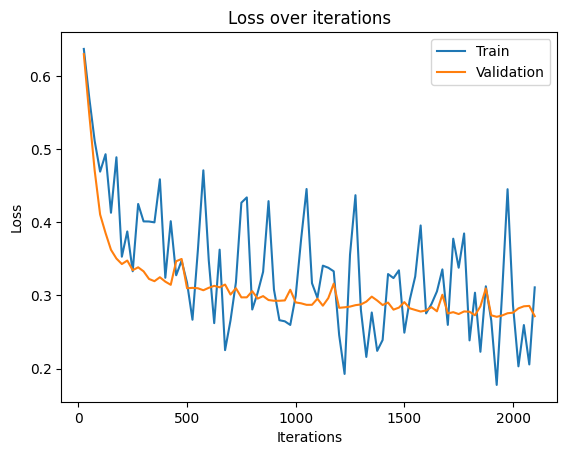

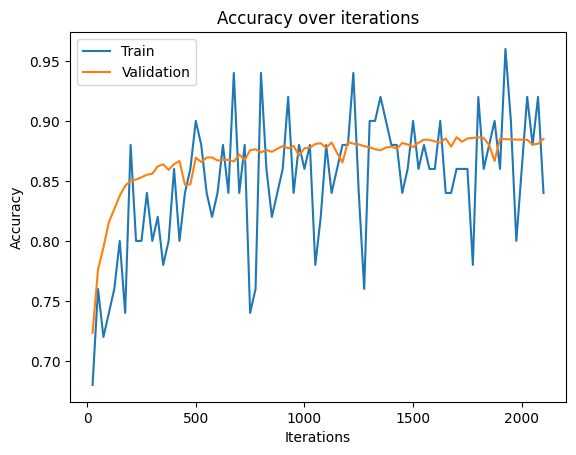

In [34]:
# fine_tuned_model = fine_tune_bert(model, train_data_indices, train_attention_masks, train_labels, val_data_indices, val_attention_masks, val_labels)
fine_tuned_model = fine_tune_bert(model, train_data_indices, train_attention_masks, train_labels, val_data_indices, val_attention_masks, val_labels)